In [1]:
import os
import torch
from torch.utils.data import Dataset
import xarray as xr
import numpy as np
import rasterio
import torchvision.transforms as transforms
from datetime import datetime
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [2]:
class MultiModalDataset(Dataset):
    def __init__(self, sentinel1_dir, sentinel2_dir, modis_dir, crop_dir, soil_dir, weather_dir, transform=None):
        """
        Initialize the dataset using Sentinel-1 folder dates (YYYY-MM-DD) and random 16x16 patches
        from a 1 mile x 1 mile area in WGS84 degrees.

        Args:
            sentinel1_dir (str): Directory for Sentinel-1 data (YYYY-MM-DD/vv.tif, vh.tif).
            sentinel2_dir (str): Directory for Sentinel-2 data (YYYY-MM-DD/B01.tif, etc.).
            modis_dir (str): Directory for MODIS data (YYYY-MM-DD/Band1.tif, etc.).
            crop_dir (str): Directory containing crop data NetCDF files (IA_year.nc).
            soil_file (str): Path to the soil NetCDF file (e.g., IA.nc) with variables 'nccpi3all', etc.
            weather_dir (str): Directory containing weather data NetCDF files (IA_year.nc).
            transform (callable, optional): Optional transform to apply to the data.
        """
        self.sentinel1_dir = sentinel1_dir
        self.sentinel2_dir = sentinel2_dir
        self.modis_dir = modis_dir
        self.cdl_dir = crop_dir
        self.soil_dir = soil_dir
        self.weather_dir = weather_dir
        self.transform = transform
        self.patch_size = 16  # 16x16 patch size
        self.delta_lat = 0.01446  # 1 mile in latitude degrees (approx.)

        # Get week_start_dates from Sentinel-1 folder, filter for April to September
        self.week_start_dates = [
            d for d in os.listdir(sentinel1_dir)
            if os.path.isdir(os.path.join(sentinel1_dir, d)) and self._is_in_april_to_september(d)
        ]
        if not self.week_start_dates:
            raise ValueError("No Sentinel-1 data found for April to September.")

        # Define all bands/variables
        self.s1_bands = ['vv', 'vh']  # 2 bands
        self.s2_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']  # 12 bands + 'B10' which is missing sometimes.
        self.modis_bands = ['Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7']  # 7 bands
        self.weather_bands = ['dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']  # 7 variables
        self.cdl_bands = ['Band_1']  # Crop Data Layer: 120 classes representing land cover uses including different crops like 'Maize', 'Soy', etc.
        self.soil_bands = ['nccpi3all', 'nccpi3corn', 'rootznaws', 'soc0_150', 'soc0_999', 'pctearthmc']  # 6 variables
        # Get spatial bounds from a sample Sentinel-1 GeoTIFF
        sample_s1_path = os.path.join(sentinel1_dir, self.week_start_dates[0], '4326_vv.tif')
        with rasterio.open(sample_s1_path) as src:
            self.bounds = src.bounds  # (left, bottom, right, top) in degrees
            self.transform_geo = src.transform  # Geotransform to convert degrees to pixels
            self.width, self.height = src.width, src.height

    def _is_in_april_to_september(self, date_str):
        """Check if date_str (YYYY-MM-DD) is between April 1st and September 30th."""
        try:
            date = datetime.strptime(date_str, '%Y-%m-%d')
            month = date.month
            day = date.day
            return (month == 4 and day >= 1) or (4 < month < 9) or (month == 9 and day <= 30)
        except ValueError:
            return False
        
    def _load_and_crop_single_band(self, path, bbox):
        """Load and crop a single-band GeoTIFF using coordinate bounds, resize to 16x16."""
        with rasterio.open(path) as src:
            window = rasterio.windows.from_bounds(*bbox, transform=src.transform)
            data = src.read(1, window=window, boundless=True, fill_value=np.nan)  # Handle out-of-bounds
            data_tensor = torch.from_numpy(data).float().unsqueeze(0)  # (1, height, width)
            resized = F.resize(data_tensor, [16, 16], interpolation=F.InterpolationMode.BILINEAR)
            return resized.squeeze(0)  # (16, 16)

    def _load_and_crop_multi_band(self, path, bbox):
        """Load and crop a multi-band GeoTIFF using coordinate bounds, resize to 16x16."""
        with rasterio.open(path) as src:
            window = rasterio.windows.from_bounds(*bbox, transform=src.transform)
            data = src.read(window=window, boundless=True, fill_value=np.nan)  # (bands, height, width)
            data_tensor = torch.from_numpy(data).float()  # (bands, height, width)
            resized = F.resize(data_tensor, [16, 16], interpolation=F.InterpolationMode.BILINEAR)
            return resized  # (bands, 16, 16)

    def _random_patch_coords(self):
        """Generate random center and calculate 1-mile x 1-mile bounding box in degrees."""
        # Get bounds from a sample GeoTIFF, e.g., Sentinel-1
        sample_path = os.path.join(self.sentinel1_dir, self.week_start_dates[0], '4326_vv.tif')
        with rasterio.open(sample_path) as src:
            bounds = src.bounds  # (left, bottom, right, top) in degrees
        
        # Random center within bounds, leaving room for 1-mile extent
        lon_min = bounds.left + self.delta_lat / 2
        lon_max = bounds.right - self.delta_lat / 2
        lat_min = bounds.bottom + self.delta_lat / 2
        lat_max = bounds.top - self.delta_lat / 2
        
        lat_center = np.random.uniform(lat_min, lat_max)
        lon_center = np.random.uniform(lon_min, lon_max)
        
        # Calculate 1-mile extents
        delta_lat = 0.01446  # Fixed for latitude
        delta_lon = delta_lat / np.cos(np.radians(lat_center))  # Adjust for latitude
        
        # Define bounding box
        left = lon_center - delta_lon / 2
        right = lon_center + delta_lon / 2
        bottom = lat_center - delta_lat / 2
        top = lat_center + delta_lat / 2
        
        return left, bottom, right, top

    def __len__(self):
        return len(self.week_start_dates)

    def __getitem__(self, idx):
        week_start_date = self.week_start_dates[idx]
        year = week_start_date.split('-')[0]
        week_start_date = self.week_start_dates[idx]
        bbox = self._random_patch_coords()  # (left, bottom, right, top)
        
        # Sentinel-1 (separate files)
        s1_folder = os.path.join(self.sentinel1_dir, week_start_date)
        s1_patches = []
        for band in self.s1_bands:
            path = os.path.join(s1_folder, f'4326_{band}.tif')
            patch = self._load_and_crop_single_band(path, bbox)
            s1_patches.append(patch)
        s1_tensor = torch.stack(s1_patches, dim=0)  # (2, 16, 16)
        
        # Sentinel-2 (separate files)
        s2_folder = os.path.join(self.sentinel2_dir, week_start_date)
        s2_patches = []
        for band in self.s2_bands:
            path = os.path.join(s2_folder, f'4326_{band}.tif')
            patch = self._load_and_crop_single_band(path, bbox)
            s2_patches.append(patch)
        s2_tensor = torch.stack(s2_patches, dim=0)  # (13, 16, 16)
        
        # MODIS (separate files)
        modis_folder = os.path.join(self.modis_dir, week_start_date)
        modis_patches = []
        for band in self.modis_bands:
            path = os.path.join(modis_folder, f'4326_{band}.tif')
            patch = self._load_and_crop_single_band(path, bbox)
            modis_patches.append(patch)
        modis_tensor = torch.stack(modis_patches, dim=0)  # (7, 16, 16)
        
        # Crop (single-band)
        crop_path = os.path.join(self.cdl_dir, f'{year}_WGS84.tif')
        cdl_tensor = self._load_and_crop_single_band(crop_path, bbox).unsqueeze(0)  # (1, 16, 16)

        # 4. soil data (all bands)
        # soil_patches = []
        # for band in self.soil_bands:
        #     path = os.path.join(self.soil_dir, f'merged_max_{band}_resampled.tif')
        #     patch = self._load_and_crop_single_band(path, bbox)
        #     soil_patches.append(patch)
        # soil_tensor = torch.stack(soil_patches, dim=0)  # (6, 16, 16)

        # 4. Weather data (all bands)
        weather_path = os.path.join(self.weather_dir, f'{week_start_date}.tif')
        weather_tensor = self._load_and_crop_multi_band(weather_path, bbox)  # (7, 16, 16)

        # Stack modalities into a list (variable channels per modality)
        modalities = [s1_tensor, s2_tensor, modis_tensor, cdl_tensor, weather_tensor]
        # Shapes: [(2, 16, 16), (13, 16, 16), (7, 16, 16), (N_crop, 16, 16), (6, 16, 16), (7, 16, 16)]

        if self.transform:
            modalities = [self.transform(m) for m in modalities]

        # Dummy label (replace with actual labels if available)
        label = 0

        return modalities, label

In [3]:
def display_sample(dataset, sample_idx=0):
    modalities, label = dataset[sample_idx]
    modality_names = ['Sentinel-1', 'Sentinel-2', 'MODIS', 'Crop', 'Weather'] # 'Soil'
    
    def normalize_channel(channel, percentile=2):
        vmin = np.percentile(channel, percentile)
        vmax = np.percentile(channel, 100 - percentile)
        channel = (channel - vmin) / (vmax - vmin)
        channel = np.clip(channel, 0, 1)
        return channel
    
    fig, axes = plt.subplots(1, len(modalities), figsize=(20, 4))
    
    for i, (modality, name) in enumerate(zip(modalities, modality_names)):
        if name == 'Crop':
            # Display segmentation map with color for each class
            label_map = modality[0].numpy()  # (16, 16)
            unique_labels = np.unique(label_map)
            num_classes = len(unique_labels)
            cmap = plt.get_cmap('tab20', num_classes)  # Use tab20 for up to 20 classes
            im = axes[i].imshow(label_map, cmap=cmap, interpolation='nearest')
            cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.05)
            cbar.set_label('Class Label')
        elif name == 'Sentinel-2':
            # RGB composite: B04 (red, index 3), B03 (green, index 2), B02 (blue, index 1)
            r = normalize_channel(modality[3].numpy())
            g = normalize_channel(modality[2].numpy())
            b = normalize_channel(modality[1].numpy())
            rgb = np.stack([r, g, b], axis=-1)
            axes[i].imshow(rgb)
        elif name == 'MODIS':
            # RGB composite: Band1 (red, index 0), Band4 (green, index 3), Band3 (blue, index 2)
            r = normalize_channel(modality[0].numpy())
            g = normalize_channel(modality[3].numpy())
            b = normalize_channel(modality[2].numpy())
            rgb = np.stack([r, g, b], axis=-1)
            axes[i].imshow(rgb)
        elif name == 'Weather':
            axes[i].imshow(modality.numpy(), cmap='pink')
        else:
            # Grayscale for other modalities, using first channel
            channel = normalize_channel(modality[0].numpy())
            axes[i].imshow(channel, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.show()

TypeError: Invalid shape (7, 16, 16) for image data

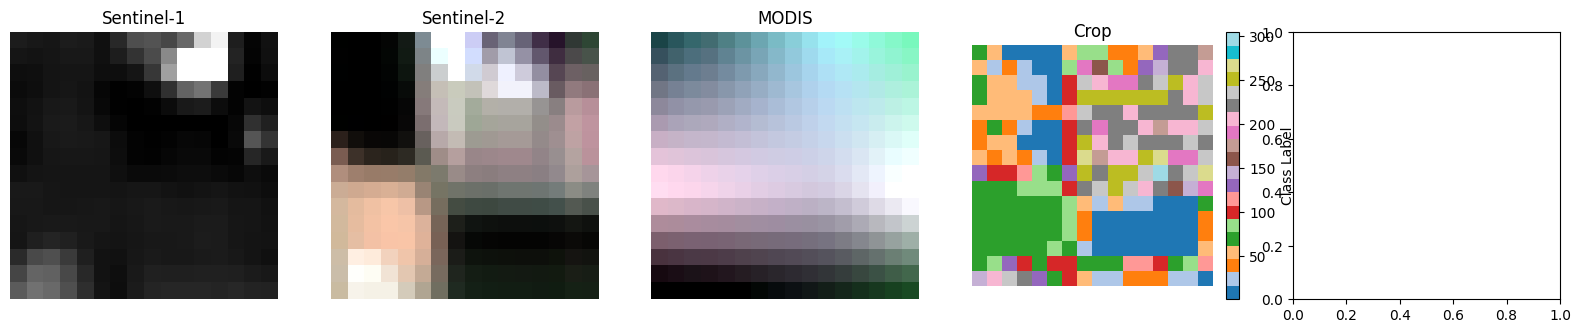

In [4]:
# Example usage:
dataset = MultiModalDataset(
    sentinel1_dir='/work/mech-ai-scratch/rtali/gis-sentinel1/final_s1',
    sentinel2_dir='/work/mech-ai-scratch/rtali/gis-sentinel2/final_s2_v3',
    modis_dir='/work/mech-ai-scratch/rtali/gis-modis/modis',
    crop_dir='/work/mech-ai-scratch/rtali/gis-CDL/final_CDL',
    soil_dir='/work/mech-ai-scratch/rtali/AI_READY_IOWA/SOIL',
    weather_dir='/work/mech-ai-scratch/rtali/AI_READY_IOWA/WEATHER_TIFFS',
    transform=transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean/std per channel if needed
)

# Get channel counts
num_channels_list = [
    len(dataset.s1_bands),      # 2 (Sentinel-1)
    len(dataset.s2_bands),      # 13 (Sentinel-2)
    len(dataset.modis_bands),   # 7 (MODIS)
    len(dataset.cdl_bands),     # Update with actual count
    len(dataset.soil_bands),     # 6 (Soil)
    len(dataset.weather_bands)   # 7 (Weather)
]
display_sample(dataset)

In [5]:
soil_dir = '/work/mech-ai-scratch/rtali/AI_READY_IOWA/SOIL'
soil_bands = ['nccpi3all', 'nccpi3corn', 'rootznaws', 'soc0_150', 'soc0_999', 'pctearthmc']  # 6 variables
path = os.path.join(soil_dir, f'merged_max_{soil_bands[0]}_resampled.tif')
bbox = dataset._random_patch_coords()  # (left, bottom, right, top)

In [10]:
with rasterio.open(path) as src:
    window = rasterio.windows.from_bounds(*bbox, transform=src.transform)
    data = src.read(1, window=window, boundless=True, fill_value=np.nan)  # Handle out-of-bounds
window


Window(col_off=np.float64(498.3962456132481), row_off=np.float64(19198.898445374576), width=np.float64(0.0001573733487134632), height=np.float64(0.00011567999899853021))

In [11]:
data

array([], shape=(0, 0), dtype=float32)

In [ ]:
sample = dataset[0][0]

In [ ]:
sample[5].shape

In [ ]:
label_map = modality[0].numpy()  # (16, 16)
unique_labels = np.unique(label_map)
num_classes = len(unique_labels)
cmap = plt.get_cmap('tab20', num_classes)  # Use tab20 for up to 20 classes
im = axes[i].imshow(label_map, cmap=cmap, interpolation='nearest')
cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.05)
cbar.set_label('Class Label')

In [ ]:
crop_dir='/work/mech-ai-scratch/rtali/AI_READY_IOWA/CDL/IN4326'
crop_file = os.path.join(crop_dir, f'IA_2023.nc')
crop_data = xr.open_dataset(crop_file)
crop_data

In [ ]:
crop_data.isel(band=0)